<a href="https://colab.research.google.com/github/Eiko58/Hippocampus_segmentation/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import time
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
from scipy.io import loadmat
import nibabel as nib
import csv
#IMAGE PROCESS
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy.ndimage.filters import convolve
from skimage import data, io, filters
import skimage
from skimage.morphology import convex_hull_image, erosion
from IPython import display
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as patches
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#MODEL LAYERS
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape, Conv2DTranspose,\
LeakyReLU, GaussianNoise, GlobalMaxPooling2D, ReLU, Input, Concatenate
#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r drive/MyDrive/MRI.zip .

In [ ]:
!unzip MRI.zip

Streaming output truncated to the last 5000 lines.
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_104.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_105.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_106.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_107.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_108.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_109.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_110.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_111.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_112.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_007_S_1304_74384_ACPC_113.jpg  
  inflating: original/35/ADNI_007_S_1304_74384_ACPC/ADNI_00

In [ ]:
!pwd

/content


In [ ]:
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

[PosixPath('.config'),
 PosixPath('label'),
 PosixPath('original'),
 PosixPath('drive'),
 PosixPath('sample_data')]

In [ ]:
Label35_Path = Path("label/35label")
Image35_Path = Path("original/35")

In [ ]:
Label_Path = list(Label35_Path.glob(r"**/*.jpg"))
Image_Path = list(Image35_Path.glob(r"**/*.jpg"))

In [ ]:
print("LABEL LEN:",len(Label_Path))
print("---"*10)
print("IMAGE LEN:",len(Image_Path))

LABEL LEN: 13230
------------------------------
IMAGE LEN: 6615


In [ ]:
Label_Series = pd.Series(Label_Path,name="LABEL").astype(str)
Image_Series = pd.Series(Image_Path,name="IMAGE").astype(str)

In [ ]:
Label_Series.head(-1)

0        label/35label/ADNI_100_S_0047_150336_tal_nosca...
1        label/35label/ADNI_100_S_0047_150336_tal_nosca...
2        label/35label/ADNI_100_S_0047_150336_tal_nosca...
3        label/35label/ADNI_100_S_0047_150336_tal_nosca...
4        label/35label/ADNI_100_S_0047_150336_tal_nosca...
                               ...                        
13224    label/35label/ADNI_023_S_0061_132164_ACPC/ADNI...
13225    label/35label/ADNI_023_S_0061_132164_ACPC/ADNI...
13226    label/35label/ADNI_023_S_0061_132164_ACPC/ADNI...
13227    label/35label/ADNI_023_S_0061_132164_ACPC/ADNI...
13228    label/35label/ADNI_023_S_0061_132164_ACPC/ADNI...
Name: LABEL, Length: 13229, dtype: object

In [ ]:
Image_Series.head(-1)

0       original/35/ADNI_100_S_0047_150336_tal_noscale...
1       original/35/ADNI_100_S_0047_150336_tal_noscale...
2       original/35/ADNI_100_S_0047_150336_tal_noscale...
3       original/35/ADNI_100_S_0047_150336_tal_noscale...
4       original/35/ADNI_100_S_0047_150336_tal_noscale...
                              ...                        
6609    original/35/ADNI_023_S_0061_132164_ACPC/ADNI_0...
6610    original/35/ADNI_023_S_0061_132164_ACPC/ADNI_0...
6611    original/35/ADNI_023_S_0061_132164_ACPC/ADNI_0...
6612    original/35/ADNI_023_S_0061_132164_ACPC/ADNI_0...
6613    original/35/ADNI_023_S_0061_132164_ACPC/ADNI_0...
Name: IMAGE, Length: 6614, dtype: object

In [ ]:
Split_Params_For_LABEL = "35label/"
Split_Params_For_IMG = "35/"

L_Main_Path,L_Target_Path = Label_Series[0].split(Split_Params_For_LABEL)
I_Main_Path,I_Target_Path = Image_Series[0].split(Split_Params_For_IMG)

print("LABEL MAIN: ",L_Main_Path)
print("LABEL TARGET: ",L_Target_Path)
print("---"*20)
print("IMG MAIN: ",I_Main_Path)
print("IMG TARGET: ",I_Target_Path)

LABEL MAIN:  label/
LABEL TARGET:  ADNI_100_S_0047_150336_tal_noscale/ADNI_100_S_0047_150336_R/ADNI_100_S_0047_150336_R_003.jpg
------------------------------------------------------------
IMG MAIN:  original/
IMG TARGET:  ADNI_100_S_0047_150336_tal_noscale/ADNI_100_S_0047_150336_tal_noscale_098.jpg


In [ ]:
Common_Params = "/"

Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
IMG_Path_Before,IMG_Path_After = I_Target_Path.split(Common_Params)

print("LABEL BEFORE: ",Label_Path_Before)
print("LABEL MIDDLE: ",Label_Path_Middle)
print("LABEL AFTER: ",Label_Path_After)
print("---"*20)
print("IMG BEFORE: ",IMG_Path_Before)
print("IMG AFTER: ",IMG_Path_After)

LABEL BEFORE:  ADNI_100_S_0047_150336_tal_noscale
LABEL MIDDLE:  ADNI_100_S_0047_150336_R
LABEL AFTER:  ADNI_100_S_0047_150336_R_003.jpg
------------------------------------------------------------
IMG BEFORE:  ADNI_100_S_0047_150336_tal_noscale
IMG AFTER:  ADNI_100_S_0047_150336_tal_noscale_098.jpg


In [ ]:
List_Split_Params = "_"

Label_Path_Split = Label_Path_After.split(List_Split_Params)
IMG_Path_Split = IMG_Path_After.split(List_Split_Params)

print("LABEL LIST: ",Label_Path_Split)
print("IMG LIST: ",IMG_Path_Split)
print("---"*20)
print("LABEL TARGET: ",Label_Path_Split[-2])
print("IMG TARGET: ",IMG_Path_Split[-1])

LABEL LIST:  ['ADNI', '100', 'S', '0047', '150336', 'R', '003.jpg']
IMG LIST:  ['ADNI', '100', 'S', '0047', '150336', 'tal', 'noscale', '098.jpg']
------------------------------------------------------------
LABEL TARGET:  R
IMG TARGET:  098.jpg


In [ ]:
if Label_Path_Split[-2] == "L":
    
    print("IT'S LEFT")
            
elif Label_Path_Split[-2] == "R":
     
    print("IT'S RIGHT")

IT'S RIGHT


In [ ]:
L_IMG = []
R_IMG = []

Total_IMG = []

Split_Params_For_LABEL = "35label/"
Split_Params_For_IMG = "35/"

Common_Params = "/"

List_Split_Params = "_"


for label_x in Label_Series:
    
    try:
        
        L_Main_Path,L_Target_Path = label_x.split(Split_Params_For_LABEL)
        

        Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
        

        Label_Path_Split = Label_Path_After.split(List_Split_Params)
        


        if Label_Path_Split[-2] == "L":

            L_IMG.append(label_x)
            
            
        elif Label_Path_Split[-2] == "R":
            
            R_IMG.append(label_x)
            
            
        else:
            print("SOMETHING IS WRONG!")
            
    except:
        print("LABEL: ",label_x)
        print("IMG: ",image_x)

Total_IMG = Image_Series.to_list()


In [ ]:
len(L_IMG), len(R_IMG), len(Total_IMG)

(6615, 6615, 6615)

In [ ]:
print(L_IMG[0])
print(Total_IMG[0])
print(R_IMG[0])

label/35label/ADNI_100_S_0047_150336_tal_noscale/ADNI_100_S_0047_150336_L/ADNI_100_S_0047_150336_L_020.jpg
original/35/ADNI_100_S_0047_150336_tal_noscale/ADNI_100_S_0047_150336_tal_noscale_098.jpg
label/35label/ADNI_100_S_0047_150336_tal_noscale/ADNI_100_S_0047_150336_R/ADNI_100_S_0047_150336_R_003.jpg


In [ ]:
Sort_L = sorted(L_IMG)
Sort_R = sorted(R_IMG)
Sort_IMG = sorted(Total_IMG)

In [ ]:
print(Sort_L[0])
print(Sort_R[0])
print(Sort_IMG[0])


label/35label/ADNI_002_S_0685_18211/ADNI_002_S_0685_18211_L/ADNI_002_S_0685_18211_L_001.jpg
label/35label/ADNI_002_S_0685_18211/ADNI_002_S_0685_18211_R/ADNI_002_S_0685_18211_R_001.jpg
original/35/ADNI_002_S_0685_18211_tal_noscale/ADNI_002_S_0685_18211_tal_noscale_001.jpg


In [ ]:
print(Sort_L[1])
print(Sort_R[1])
print(Sort_IMG[1])

label/35label/ADNI_002_S_0685_18211/ADNI_002_S_0685_18211_L/ADNI_002_S_0685_18211_L_002.jpg
label/35label/ADNI_002_S_0685_18211/ADNI_002_S_0685_18211_R/ADNI_002_S_0685_18211_R_002.jpg
original/35/ADNI_002_S_0685_18211_tal_noscale/ADNI_002_S_0685_18211_tal_noscale_002.jpg


In [ ]:
print(Sort_L[190])
print(Sort_R[190])
print(Sort_IMG[190])

label/35label/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_L/ADNI_002_S_1070_130146_L_002.jpg
label/35label/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_R/ADNI_002_S_1070_130146_R_002.jpg
original/35/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_ACPC_002.jpg


In [ ]:
Sort_IMG.index('original/35/ADNI_002_S_1261_223901_ACPC/ADNI_002_S_1261_223901_ACPC_002.jpg')

568

In [ ]:
Sort_L.index('label/35label/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_L/ADNI_002_S_1070_130146_L_002.jpg') #same result for 'L' and 'R'

190

In [ ]:
print(Sort_L[191])
print(Sort_R[191])
print(Sort_IMG[191])

label/35label/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_L/ADNI_002_S_1070_130146_L_003.jpg
label/35label/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_R/ADNI_002_S_1070_130146_R_003.jpg
original/35/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_ACPC_003.jpg


In [ ]:
L_IMG = []
R_IMG = []

Total_IMG = []

Split_Params_For_LABEL = "35label/"
Split_Params_For_IMG = "35/"

Common_Params = "/"

for l_img in Sort_L:
  L_Main_Path,L_Target_Path = l_img.split(Split_Params_For_LABEL)
  Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
  check_patient = Label_Path_After[:-10]
  check_picturenr = l_img[-7:-4]
  index = False
  for i in range(len(Sort_IMG)):
    if check_patient in Sort_IMG[i] and check_picturenr == Sort_IMG[i][-7:-4]:
      index = i
  if not index:
    continue
  index_R = False
  for i in range(len(Sort_R)):
    if check_patient in Sort_R[i] and check_picturenr == Sort_R[i][-7:-4]:
      index_R = i
  if not index_R:
    continue
  else:
    L_IMG.append(l_img)
    R_IMG.append(Sort_R[index_R])
    Total_IMG.append(Sort_IMG[index])


In [ ]:
len(L_IMG), len(R_IMG), len(Total_IMG)

(6614, 6614, 6614)

In [ ]:
Sort_L = sorted(L_IMG)
Sort_R = sorted(R_IMG)
Sort_IMG = sorted(Total_IMG)

In [ ]:
print(Sort_L[0])
print(Sort_R[0])
print(Sort_IMG[0])

label/35label/ADNI_002_S_0685_18211/ADNI_002_S_0685_18211_L/ADNI_002_S_0685_18211_L_002.jpg
label/35label/ADNI_002_S_0685_18211/ADNI_002_S_0685_18211_R/ADNI_002_S_0685_18211_R_002.jpg
original/35/ADNI_002_S_0685_18211_tal_noscale/ADNI_002_S_0685_18211_tal_noscale_002.jpg


In [ ]:
print(Sort_L[188])
print(Sort_R[188])
print(Sort_IMG[188])

label/35label/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_L/ADNI_002_S_1070_130146_L_001.jpg
label/35label/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_R/ADNI_002_S_1070_130146_R_001.jpg
original/35/ADNI_002_S_1070_130146_ACPC/ADNI_002_S_1070_130146_ACPC_001.jpg


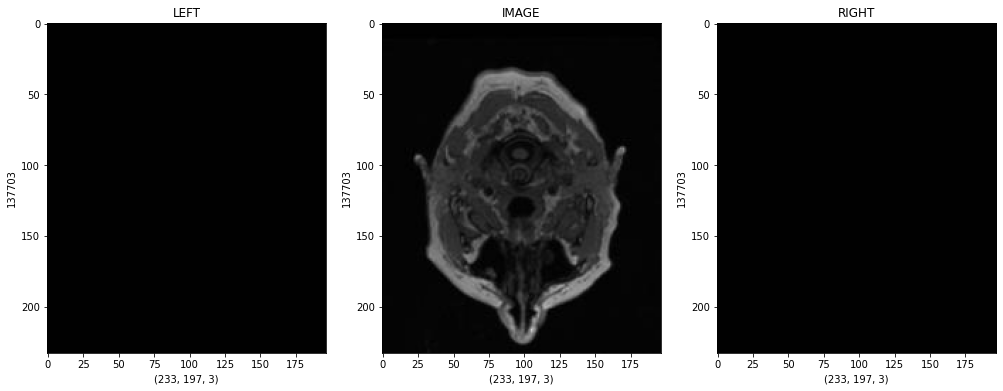

In [ ]:
figure,axis = plt.subplots(1,3,figsize=(17,17))

Example_L = cv2.cvtColor(cv2.imread(Sort_L[0]),cv2.COLOR_BGR2RGB)
Example_R = cv2.cvtColor(cv2.imread(Sort_R[0]),cv2.COLOR_BGR2RGB)
Example_IMG = cv2.cvtColor(cv2.imread(Sort_IMG[0]),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_L.shape)
axis[0].set_ylabel(Example_L.size)
axis[0].set_title("LEFT")
axis[0].imshow(Example_L)

axis[1].set_xlabel(Example_IMG.shape)
axis[1].set_ylabel(Example_IMG.size)
axis[1].set_title("IMAGE")
axis[1].imshow(Example_IMG)

axis[2].set_xlabel(Example_R.shape)
axis[2].set_ylabel(Example_R.size)
axis[2].set_title("RIGHT")
axis[2].imshow(Example_R)

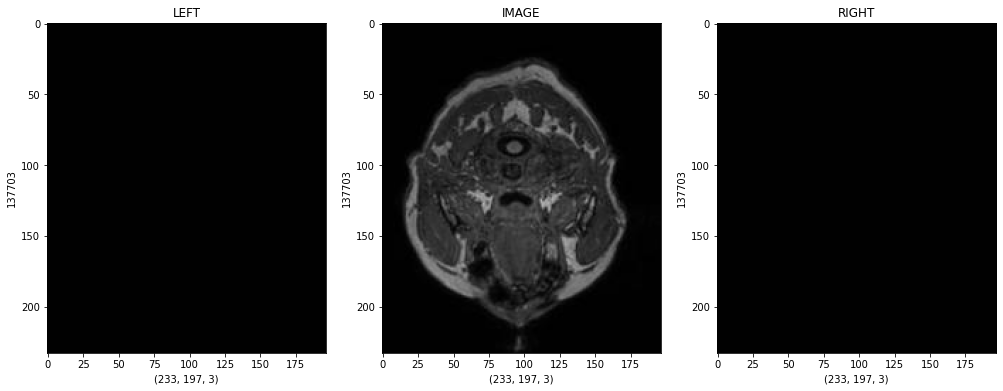

In [ ]:


figure,axis = plt.subplots(1,3,figsize=(17,17))

Example_L = cv2.cvtColor(cv2.imread(Sort_L[189]),cv2.COLOR_BGR2RGB)
Example_R = cv2.cvtColor(cv2.imread(Sort_R[189]),cv2.COLOR_BGR2RGB)
Example_IMG = cv2.cvtColor(cv2.imread(Sort_IMG[189]),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_L.shape)
axis[0].set_ylabel(Example_L.size)
axis[0].set_title("LEFT")
axis[0].imshow(Example_L)

axis[1].set_xlabel(Example_IMG.shape)
axis[1].set_ylabel(Example_IMG.size)
axis[1].set_title("IMAGE")
axis[1].imshow(Example_IMG)

axis[2].set_xlabel(Example_R.shape)
axis[2].set_ylabel(Example_R.size)
axis[2].set_title("RIGHT")
axis[2].imshow(Example_R)



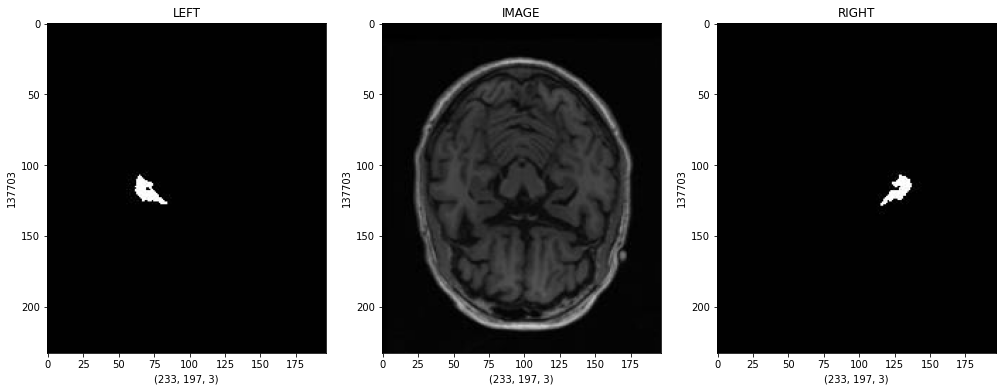

In [ ]:
figure,axis = plt.subplots(1,3,figsize=(17,17))

Example_L = cv2.cvtColor(cv2.imread(Sort_L[53]),cv2.COLOR_BGR2RGB)
Example_R = cv2.cvtColor(cv2.imread(Sort_R[53]),cv2.COLOR_BGR2RGB)
Example_IMG = cv2.cvtColor(cv2.imread(Sort_IMG[53]),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_L.shape)
axis[0].set_ylabel(Example_L.size)
axis[0].set_title("LEFT")
axis[0].imshow(Example_L)

axis[1].set_xlabel(Example_IMG.shape)
axis[1].set_ylabel(Example_IMG.size)
axis[1].set_title("IMAGE")
axis[1].imshow(Example_IMG)

axis[2].set_xlabel(Example_R.shape)
axis[2].set_ylabel(Example_R.size)
axis[2].set_title("RIGHT")
axis[2].imshow(Example_R)

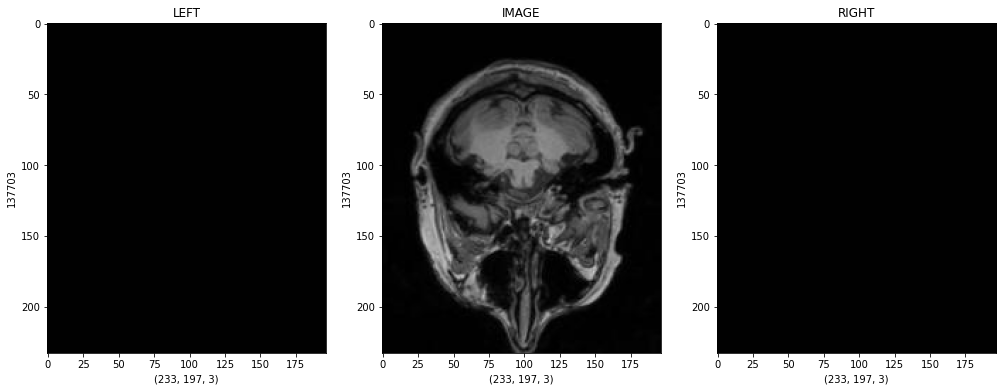

In [ ]:
figure,axis = plt.subplots(1,3,figsize=(17,17))

Example_L = cv2.cvtColor(cv2.imread(Sort_L[2510]),cv2.COLOR_BGR2RGB)
Example_R = cv2.cvtColor(cv2.imread(Sort_R[2510]),cv2.COLOR_BGR2RGB)
Example_IMG = cv2.cvtColor(cv2.imread(Sort_IMG[2510]),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_L.shape)
axis[0].set_ylabel(Example_L.size)
axis[0].set_title("LEFT")
axis[0].imshow(Example_L)

axis[1].set_xlabel(Example_IMG.shape)
axis[1].set_ylabel(Example_IMG.size)
axis[1].set_title("IMAGE")
axis[1].imshow(Example_IMG)

axis[2].set_xlabel(Example_R.shape)
axis[2].set_ylabel(Example_R.size)
axis[2].set_title("RIGHT")
axis[2].imshow(Example_R)

In [ ]:
print(Sort_L[2510])
print(Sort_R[2510])
print(Sort_IMG[2510])

label/35label/ADNI_100_S_0047_150336_tal_noscale/ADNI_100_S_0047_150336_L/ADNI_100_S_0047_150336_L_055.jpg
label/35label/ADNI_100_S_0047_150336_tal_noscale/ADNI_100_S_0047_150336_R/ADNI_100_S_0047_150336_R_055.jpg
original/35/ADNI_100_S_0047_150336_tal_noscale/ADNI_100_S_0047_150336_tal_noscale_055.jpg


In [ ]:
te_L = Sort_L
te_R = Sort_R
te_IMG = Sort_IMG

**SAME FOR TRAIN SET (=100)**

In [ ]:
Label100_Path = Path("label/100label")
Image100_Path = Path("original/100")
Label_Path = list(Label100_Path.glob(r"**/*.jpg"))
Image_Path = list(Image100_Path.glob(r"**/*.jpg"))

In [ ]:
len(Label_Path), len(Image_Path)

(37611, 18900)

In [ ]:
Label_Series = pd.Series(Label_Path,name="LABEL").astype(str)
Image_Series = pd.Series(Image_Path,name="IMAGE").astype(str)

In [ ]:
len(Label_Series), len(Image_Series)

(37611, 18900)

In [ ]:
Split_Params_For_LABEL = "100label/"
Split_Params_For_IMG = "100/"
Common_Params = "/"
List_Split_Params = "_"

In [ ]:
L_IMG = []
R_IMG = []

Total_IMG = []

for label_x in Label_Series:
    
    try:
        
        L_Main_Path,L_Target_Path = label_x.split(Split_Params_For_LABEL)
        
        Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
        

        Label_Path_Split = Label_Path_After.split(List_Split_Params)
        


        if Label_Path_Split[-2] == "L":

            L_IMG.append(label_x)
            
            
        elif Label_Path_Split[-2] == "R":
            
            R_IMG.append(label_x)
            
            
        else:
            print("SOMETHING IS WRONG!")
            
    except:
        print("LABEL: ",label_x)
        

Total_IMG = Image_Series.to_list()

In [ ]:
len(L_IMG), len(R_IMG), len(Total_IMG)

(18900, 18711, 18900)

In [ ]:
Sort_L = sorted(L_IMG)
Sort_R = sorted(R_IMG)
Sort_IMG = sorted(Total_IMG)

In [ ]:
print(Sort_L[0])
print(Sort_R[0])
print(Sort_IMG[0])

label/100label/ADNI_002_S_0295_13722_ACPC/ADNI_002_S_0295_13722_L/ADNI_002_S_0295_13722_L_001.jpg
label/100label/ADNI_002_S_0295_13722_ACPC/ADNI_002_S_0295_13722_R/ADNI_002_S_0295_13722_R_001.jpg
original/100/ADNI_002_S_0295_13722_ACPC/ADNI_002_S_0295_13722_ACPC_001.jpg


In [ ]:
L_IMG = []
R_IMG = []

Total_IMG = []

for l_img in Sort_L:
  L_Main_Path,L_Target_Path = l_img.split(Split_Params_For_LABEL)
  Label_Path_Before,Label_Path_Middle,Label_Path_After = L_Target_Path.split(Common_Params)
  check_patient = Label_Path_After[:-10]
  check_picturenr = l_img[-7:-4]
  index = False
  for i in range(len(Sort_IMG)):
    if check_patient in Sort_IMG[i] and check_picturenr == Sort_IMG[i][-7:-4]:
      index = i
  if not index:
    continue
  index_R = False
  for i in range(len(Sort_R)):
    if check_patient in Sort_R[i] and check_picturenr == Sort_R[i][-7:-4]:
      index_R = i
  if not index_R:
    continue
  else:
    L_IMG.append(l_img)
    R_IMG.append(Sort_R[index_R])
    Total_IMG.append(Sort_IMG[index])


In [ ]:
len(Total_IMG), len(L_IMG), len(R_IMG)

(18710, 18710, 18710)

In [ ]:
Sort_L = sorted(L_IMG)
Sort_R = sorted(R_IMG)
Sort_IMG = sorted(Total_IMG)

In [ ]:
print(Sort_L[0])
print(Sort_R[0])
print(Sort_IMG[0])

label/100label/ADNI_002_S_0295_13722_ACPC/ADNI_002_S_0295_13722_L/ADNI_002_S_0295_13722_L_002.jpg
label/100label/ADNI_002_S_0295_13722_ACPC/ADNI_002_S_0295_13722_R/ADNI_002_S_0295_13722_R_002.jpg
original/100/ADNI_002_S_0295_13722_ACPC/ADNI_002_S_0295_13722_ACPC_002.jpg


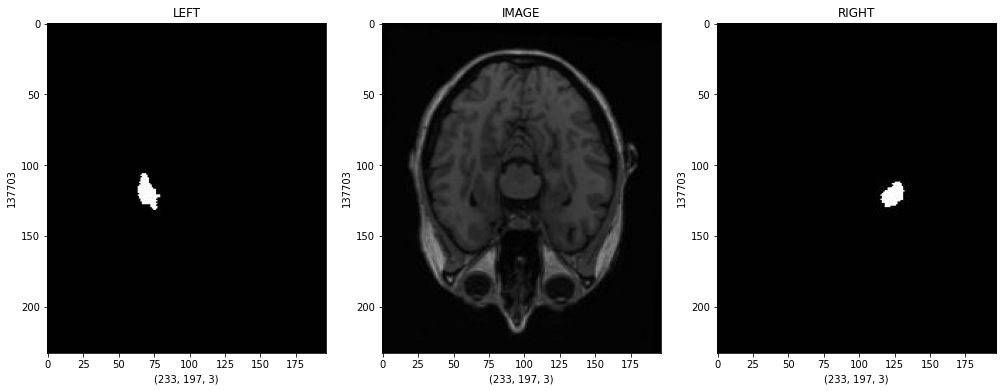

In [ ]:
figure,axis = plt.subplots(1,3,figsize=(17,17))

Example_L = cv2.cvtColor(cv2.imread(Sort_L[257]),cv2.COLOR_BGR2RGB)
Example_R = cv2.cvtColor(cv2.imread(Sort_R[257]),cv2.COLOR_BGR2RGB)
Example_IMG = cv2.cvtColor(cv2.imread(Sort_IMG[257]),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_L.shape)
axis[0].set_ylabel(Example_L.size)
axis[0].set_title("LEFT")
axis[0].imshow(Example_L)

axis[1].set_xlabel(Example_IMG.shape)
axis[1].set_ylabel(Example_IMG.size)
axis[1].set_title("IMAGE")
axis[1].imshow(Example_IMG)

axis[2].set_xlabel(Example_R.shape)
axis[2].set_ylabel(Example_R.size)
axis[2].set_title("RIGHT")
axis[2].imshow(Example_R)

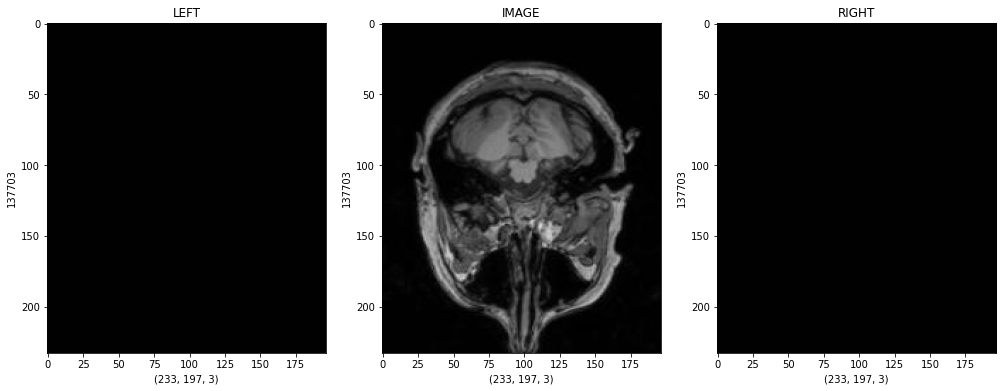

In [ ]:
figure,axis = plt.subplots(1,3,figsize=(17,17))

Example_L = cv2.cvtColor(cv2.imread(te_L[2507]),cv2.COLOR_BGR2RGB)
Example_R = cv2.cvtColor(cv2.imread(te_R[2507]),cv2.COLOR_BGR2RGB)
Example_IMG = cv2.cvtColor(cv2.imread(te_IMG[2507]),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_L.shape)
axis[0].set_ylabel(Example_L.size)
axis[0].set_title("LEFT")
axis[0].imshow(Example_L)

axis[1].set_xlabel(Example_IMG.shape)
axis[1].set_ylabel(Example_IMG.size)
axis[1].set_title("IMAGE")
axis[1].imshow(Example_IMG)

axis[2].set_xlabel(Example_R.shape)
axis[2].set_ylabel(Example_R.size)
axis[2].set_title("RIGHT")
axis[2].imshow(Example_R)

<function matplotlib.pyplot.show>

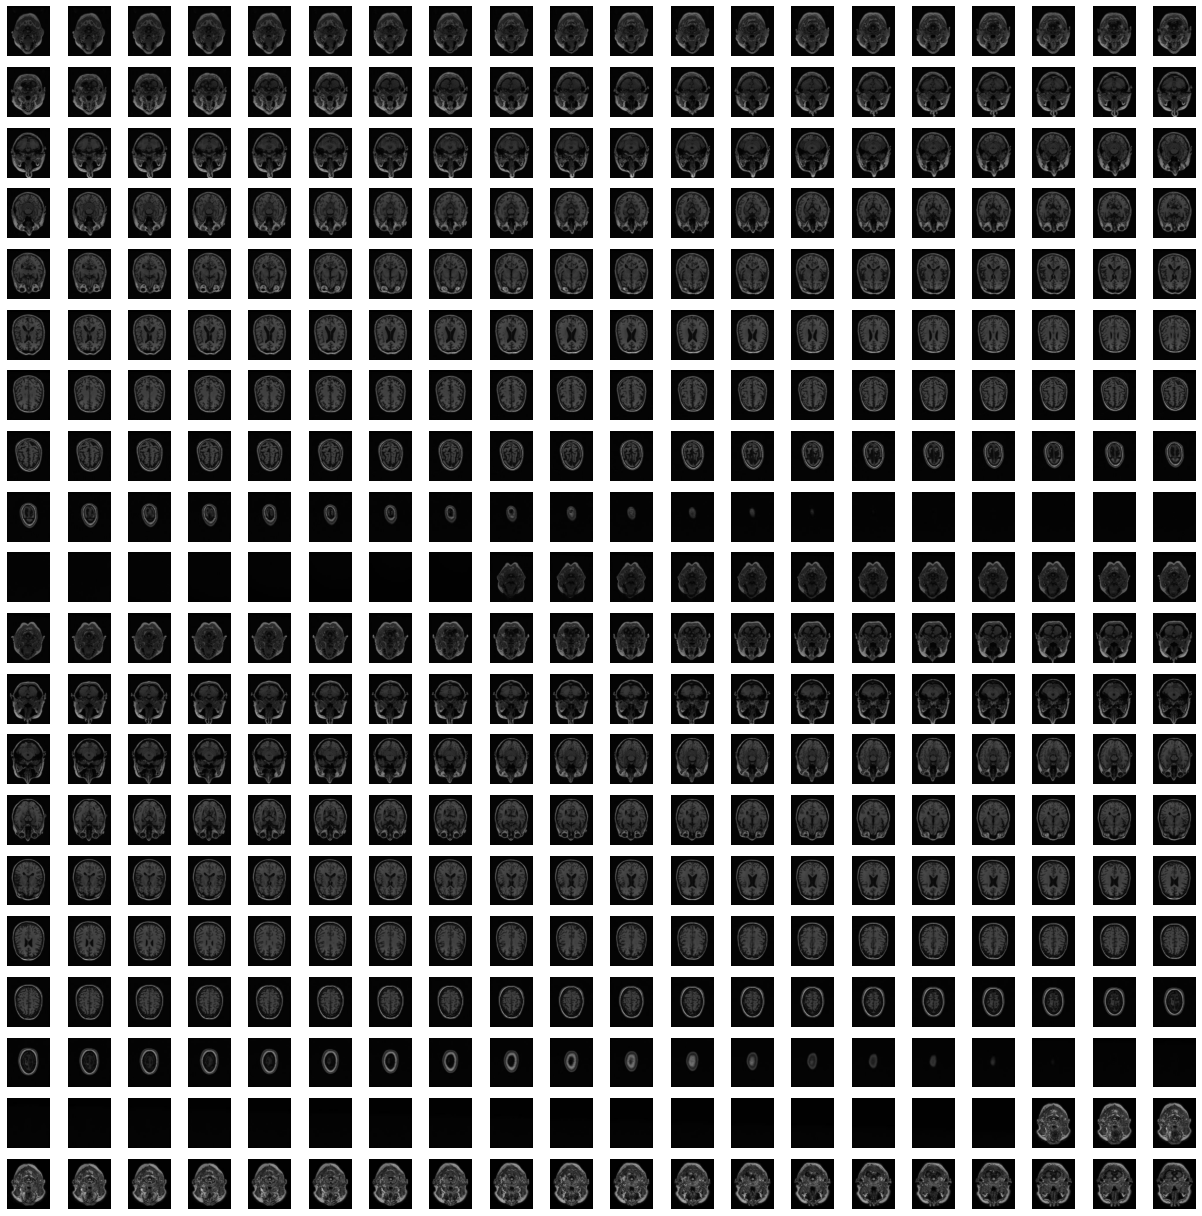

In [ ]:
figure,axis = plt.subplots(20,20,figsize=(17,17))

for indexing,operations in enumerate(axis.flat):
    
    Example_IMG = cv2.cvtColor(cv2.imread(Sort_IMG[indexing]),cv2.COLOR_BGR2RGB)
    
    operations.imshow(Example_IMG)
    operations.axis("off")

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show>

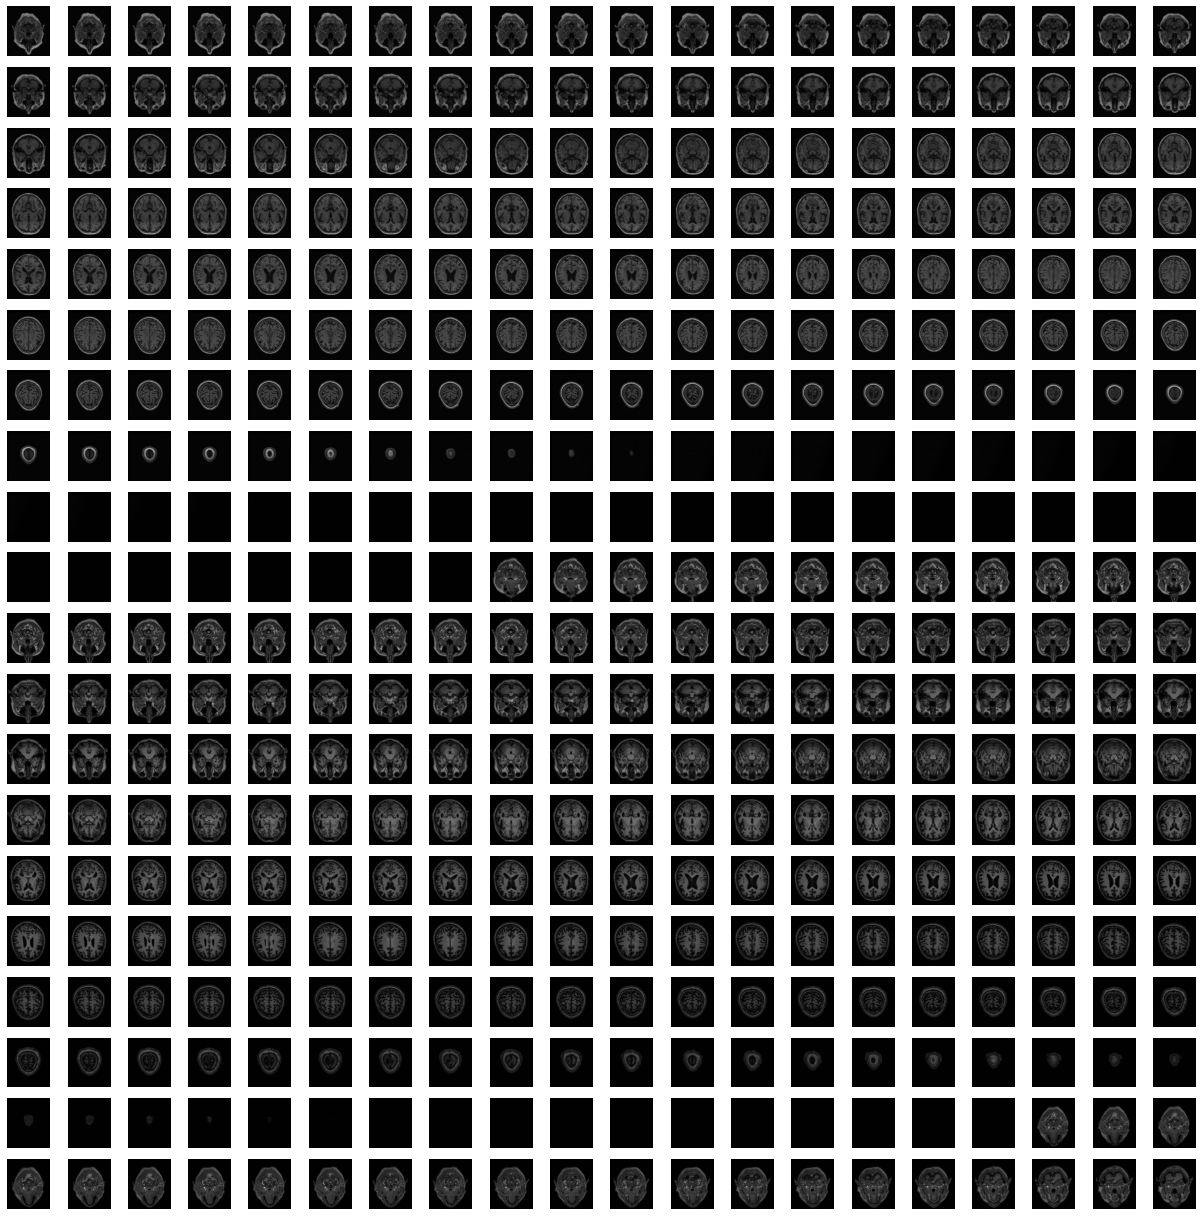

In [ ]:
figure,axis = plt.subplots(20,20,figsize=(17,17))

for indexing,operations in enumerate(axis.flat):
    
    Example_IMG = cv2.cvtColor(cv2.imread(te_IMG[indexing]),cv2.COLOR_BGR2RGB)
    
    operations.imshow(Example_IMG)
    operations.axis("off")

plt.tight_layout()
plt.show

In [ ]:
tr_R = Sort_R
tr_L = Sort_L
tr_IMG = Sort_IMG

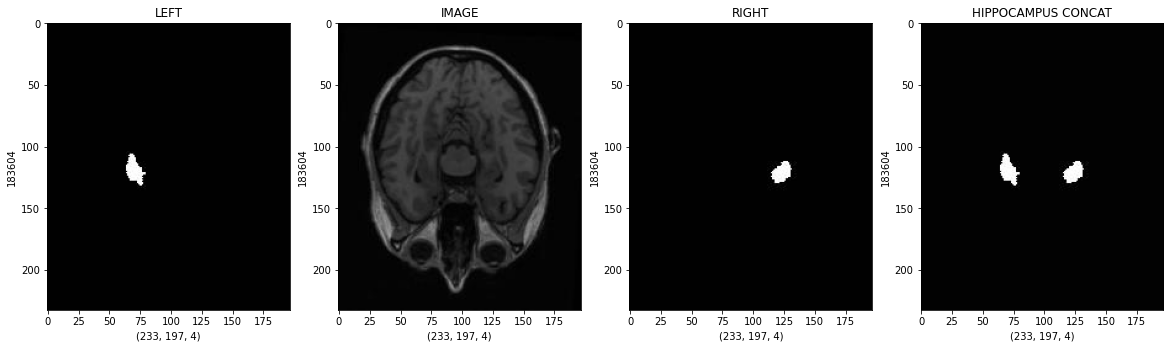

In [ ]:
Example_L = cv2.cvtColor(cv2.imread(tr_L[257]), cv2.IMREAD_GRAYSCALE)
Example_R = cv2.cvtColor(cv2.imread(tr_R[257]), cv2.IMREAD_GRAYSCALE)
Example_IMG = cv2.cvtColor(cv2.imread(tr_IMG[257]), cv2.IMREAD_GRAYSCALE)

Hıppocampus_Concat = cv2.addWeighted(Example_L,1,Example_R,1,0.2)

figure,axis = plt.subplots(1,4,figsize=(20,20))

axis[0].set_xlabel(Example_L.shape)
axis[0].set_ylabel(Example_L.size)
axis[0].set_title("LEFT")
axis[0].imshow(Example_L)

axis[1].set_xlabel(Example_IMG.shape)
axis[1].set_ylabel(Example_IMG.size)
axis[1].set_title("IMAGE")
axis[1].imshow(Example_IMG)

axis[2].set_xlabel(Example_R.shape)
axis[2].set_ylabel(Example_R.size)
axis[2].set_title("RIGHT")
axis[2].imshow(Example_R)

axis[3].set_xlabel(Hıppocampus_Concat.shape)
axis[3].set_ylabel(Hıppocampus_Concat.size)
axis[3].set_title("HIPPOCAMPUS CONCAT")
axis[3].imshow(Hıppocampus_Concat)


In [ ]:
Hıppocampus_Concat.max(), Hıppocampus_Concat.min()

(255, 1)

In [ ]:
list_hip = []
list_IMG = []
path_hip = []
path_IMG = []
split = "/"

for L_IMG, R_IMG, Total_IMG in zip(tr_L, tr_R, tr_IMG):
  Example_L = cv2.cvtColor(cv2.imread(tr_L[257]),cv2.COLOR_BGR2RGB)
  Example_R = cv2.cvtColor(cv2.imread(tr_R[257]),cv2.COLOR_BGR2RGB)
  Example_IMG = cv2.cvtColor(cv2.imread(tr_IMG[257]),cv2.COLOR_BGR2RGB)

  Hippocampus_Concat = cv2.addWeighted(Example_L,1,Example_R,1,0.2)
  list_hip.append(Hippocampus_Concat)
  list_IMG.append(Example_IMG)

  IMG_name = Total_I
  path_IMG.append()
  path_hip.append(patient_nr.replace('L', 'hip'))

In [ ]:
abc=tr_L[0]
print(abc)
abc.split('/')[-1]

label/100label/ADNI_002_S_0295_13722_ACPC/ADNI_002_S_0295_13722_L/ADNI_002_S_0295_13722_L_002.jpg


['label',
 '100label',
 'ADNI_002_S_0295_13722_ACPC',
 'ADNI_002_S_0295_13722_L',
 'ADNI_002_S_0295_13722_L_002.jpg']

In [ ]:
print(path_hip[:5])

['ADNI_002_S_0295_13722_hip_002.jpg', 'ADNI_002_S_0295_13722_hip_003.jpg', 'ADNI_002_S_0295_13722_hip_004.jpg', 'ADNI_002_S_0295_13722_hip_005.jpg', 'ADNI_002_S_0295_13722_hip_006.jpg']
['ADNI_002_S_0295_13722_ACPC_002.jpg', 'ADNI_002_S_0295_13722_ACPC_003.jpg', 'ADNI_002_S_0295_13722_ACPC_004.jpg', 'ADNI_002_S_0295_13722_ACPC_005.jpg', 'ADNI_002_S_0295_13722_ACPC_006.jpg']


In [ ]:
np.array(list_hip).shape, np.array(list_IMG).shape

(18710, 18710, 18710, 18710)

In [ ]:
DIR = 'drive/MyDrive/hippocampus'
os.mkdir(DIR)


FileExistsError: ignored

In [ ]:
DIR0 = DIR+'/train'
DIR1 = DIR0+'/label'
DIR2 = DIR0+'/Total'

FileExistsError: ignored

In [ ]:
os.mkdir(DIR0)
os.mkdir(DIR1)
os.mkdir(DIR2)